# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

Blue Score:
- https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

from torchtext.data.metrics import bleu_score

candidate_corpus = [['The', 'cat', 'is', 'on','the','table']]
references_corpus = [
    
        [['The', 'cat', 'is', 'on','the','table']]]

print(len(candidate_corpus))
print(len(references_corpus))
    
                    
bleu_score(candidate_corpus, references_corpus,max_n=4, weights=[0.25, 0.25, 0.25,0.25])

In [1]:
# Custom functionalities
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset

import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss as CEL
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [2]:
## DATASET PARAMETERS ##
data_path = "Data/eng_ita.tsv"
limit_data = 500
start_token = '<BoS>'
end_token = '<EoS>'
seq_len = 10
embedding_size = 256
batch_size = 100

# Import datasets
dataset = LanguageDataset(data_path = data_path, start_token = start_token, end_token = end_token, seq_len = seq_len, limit_data = limit_data)
train_set, val_set, test_set = dataset.get_datasets()

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

# Create dataloaders
trainloader = DataLoader(train_set, batch_size = batch_size)
valloader = DataLoader(val_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))
print("--------------------------------------------")
print("Train set dimension: {}".format(train_set.__len__()))
print("Val set dimension: {}".format(val_set.__len__()))
print("Test set dimension: {}".format(test_set.__len__()))

English vocabulary size for training: 530
Italian vocabulary size for training: 769
--------------------------------------------
Train set dimension: 357
Val set dimension: 36
Test set dimension: 107


EPOCH 1: train loss = 5.612, validation loss = 5.412
EPOCH 2: train loss = 4.597, validation loss = 5.286
EPOCH 3: train loss = 4.222, validation loss = 5.123
EPOCH 4: train loss = 3.966, validation loss = 5.079
EPOCH 5: train loss = 3.775, validation loss = 5.05
EPOCH 6: train loss = 3.671, validation loss = 5.083
EPOCH 7: train loss = 3.567, validation loss = 5.191
EPOCH 8: train loss = 3.45, validation loss = 5.209
EPOCH 9: train loss = 3.324, validation loss = 5.18
EPOCH 10: train loss = 3.209, validation loss = 5.124
--------------------------------
Time required: 6.011941432952881


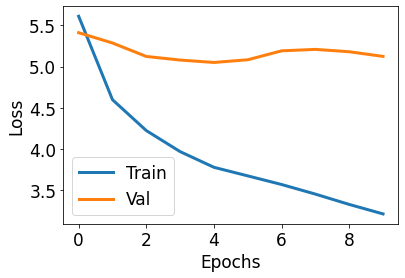

In [3]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters()), 
                 decoder_optimizer = Adam(decoder.parameters()),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

start_time = time.time()
L_train, L_val = model.train_model(trainloader,
                      valloader,
                      max_epochs = 10,
                      save_every_epochs = 20,
                      ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L_train, linewidth = 3, label = "Train")
ax.plot(L_val, linewidth = 3, label = "Val")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend();

## Evaluation

In [4]:
enc_ckp = None # "test_enc_20.pth"
dec_ckp = None # "test_dec_20.pth"

X, y, trans = model.evaluate_model(testloader, max_length = 20, enc_ckp = enc_ckp, dec_ckp = dec_ckp)

In [7]:
ids = 34
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> You re really not stupid <EoS> <UNK> <UNK> <UNK>
Italian:  <BoS> Davvero non sei stupido <EoS> <UNK> <UNK> <UNK> <UNK>
Translation:  <BoS> Non è <EoS> <EoS> <EoS> <UNK> <UNK> <UNK> <UNK>


In [8]:
ids = 12
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> You d be surprised what you can learn in
Italian:  <BoS> Sareste sorprese di quello che potete imparare in una
Translation:  <BoS> Non non non non non non <UNK> <UNK> <UNK>


In [9]:
ids = 67
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> You never have time for important things <EoS> <UNK>
Italian:  <BoS> Non ha mai tempo per le cose importanti <EoS>
Translation:  <BoS> Non è è è <EoS> <EoS> <UNK> <UNK> <UNK>
